In [1]:
# libraries
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow import math as TFmath
import math,os,shutil
from prettytable import PrettyTable
import scipy.stats as stats
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)
tf.random.set_seed(256)


TensorFlow version: 2.19.0


In [2]:
# Full paths to training data
TRAIN_FEATURE_PATH = "../Features/Train/train_features.csv"
TRAIN_LABEL_PATH   = "../Features/Train/train_labels.csv"

# Full path to test data
TEST_FEATURE_PATH = "../Features/Test/test_features.csv"

# Output folders
figure_prepath = "../figures/"
model_prepath = "../model/"

# Create output folders if not existed
os.makedirs(figure_prepath, exist_ok=True)
os.makedirs(model_prepath, exist_ok=True)

# Plotting configuration
figureFrontSize = 12
figureName_post = "_test.png"


In [3]:
### helper labels - fixed
Numchannels = 95
num_inputFeatures = Numchannels * 2 + 4 # target_gain, target_gain_tilt, EDFA_input_power_total, EDFA_output_power_total
labels = {"gainValue":'target_gain',
          "EDFA_input":'EDFA_input_power_total',
          "EDFA_output":'EDFA_output_power_total',
          "inSpectra":'EDFA_input_spectra_',
          "WSS":'DUT_WSS_activated_channel_index_',
          "result":'calculated_gain_spectra_'}
inSpectra_labels = [labels['inSpectra']+str(i).zfill(2) for i in range(0,Numchannels)]
onehot_labels = [labels['WSS']+str(i).zfill(2) for i in range(0,Numchannels)]
result_labels = [labels['result']+str(i).zfill(2) for i in range(0,Numchannels)]
preProcess_labels = [labels['EDFA_input'],labels['EDFA_output']]
preProcess_labels.extend(inSpectra_labels)

In [4]:
def dB_to_linear(data):
  return np.power(10,data/10)

def linear_TO_Db(data):
  result = 10*np.log10(data).to_numpy()
  return result[result != -np.inf]

def linear_TO_Db_full(data):
  result = 10*np.log10(data).to_numpy()
  result[result == -np.inf] = 0
  return result

def divideZero(numerator,denominator):
  with np.errstate(divide='ignore'):
    result = numerator / denominator
    result[denominator == 0] = 0
  return result

In [5]:
### train and loss function
def custom_loss(y_actual,y_pred):
  # calculate the loaded channel numbers for each batch
  # batch default is [batch size=32, outputchannel number]
  loaded_size = tf.dtypes.cast(TFmath.count_nonzero(y_actual), tf.float32)
  # turn unloaded y_pred prediction to zero
  y_pred_cast_unloaded_to_zero = TFmath.divide_no_nan(TFmath.multiply(y_pred,y_actual),y_actual)
  # error [unloaded,unloaded,loaded,loaded]: y_pred = [13->0,15->0,18.5,18.3], y_actual = [0,0,18.2,18.2]
  error = TFmath.abs(TFmath.subtract(y_pred_cast_unloaded_to_zero,y_actual))
  # custom_loss = (0.3+0.2) / 2
  custom_loss = TFmath.divide(TFmath.reduce_sum(error),loaded_size)
  return custom_loss

def custom_loss_L2(y_actual,y_pred):
  loaded_size = tf.dtypes.cast(TFmath.count_nonzero(y_actual), tf.float32)
  y_pred_cast_unloaded_to_zero = TFmath.divide_no_nan(TFmath.multiply(y_pred,y_actual),y_actual)
  error = TFmath.square(TFmath.subtract(y_pred_cast_unloaded_to_zero,y_actual))
  custom_loss = TFmath.sqrt(TFmath.divide(TFmath.reduce_sum(error),loaded_size))
  return custom_loss
    

In [6]:
def designed_DNN_model(outputNum):
  model = keras.Sequential([
      # normalizationLayer,
      layers.Dense(num_inputFeatures, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(outputNum),
  ])

  model.compile(loss=custom_loss_L2, # custom_loss
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

### debug function after train -> go to csv
def plot_loss(indx,history,ingnoreIndex):
    plt.figure(indx)
    plt.plot(history.history['loss'][ingnoreIndex:], label='loss')
    plt.plot(history.history['val_loss'][ingnoreIndex:], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [gain]')
    plt.legend()
    plt.grid(True)

def figure_comp(figIndx,y_test_result,y_pred_result,filename,setFrontSize):
    plt.figure(figIndx)
    plt.axes(aspect='equal')
    plt.scatter(y_test_result, y_pred_result)
    plt.xlabel('Measured EDFA Gain (dB)', fontsize=setFrontSize)
    plt.ylabel('predicted EDFA Gain (dB)', fontsize=setFrontSize)
    minAxis = math.floor(min(y_test_result.min(),y_pred_result.min()) - 0.5)
    maxAxis = math.ceil (max(y_test_result.max(),y_pred_result.max()) + 0.5)
    # print(min(y_test_result.min(),y_pred_result.min()),max(y_test_result.max(),y_pred_result.max()))
    # print(minAxis,maxAxis)
    limss = [*np.arange(minAxis,maxAxis+1,1)]
    lims = [limss[0],limss[-1]]
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot(lims, lims, 'k--')
    plt.xticks(ticks=limss,labels=limss,fontsize=setFrontSize)
    plt.yticks(fontsize=setFrontSize)
    plt.savefig(figure_prepath+filename, dpi=900)

def figure_hist(figIndx,error,filename,setFrontSize):
    plt.figure(figIndx)
    bins_list = [*np.arange(-0.6,0.7,0.1)]
    labelList = ['-0.6','','-0.4','','-0.2','','0.0','','0.2','','0.4','','0.6']
    plt.hist(error, bins=bins_list)
    for i in [-0.2,-0.1,0.1,0.2]: # helper vertical line
        plt.axvline(x=i,color='black',ls='--')
    plt.xlabel('Prediction Gain Error (dB)', fontsize=setFrontSize)
    plt.ylabel('Histogram', fontsize=setFrontSize)
    plt.xticks(ticks=bins_list, labels=labelList, fontsize=setFrontSize)
    plt.yticks(fontsize=setFrontSize)
    plt.savefig(figure_prepath+filename, dpi=900)

def plot_per_channel_error(y_pred,y_test):
    y_pred_result = linear_TO_Db_full(y_pred)
    y_test_result = linear_TO_Db_full(y_test)
    error = y_test_result - y_pred_result
    error_min_0_1s,error_means,error_min_0_2s,within95ranges,mses = [],[],[],[],[]
    for j in range(len(error[0])):
        error_channel = error[:,j]
        error_channel = error_channel[error_channel!=0]
        # calculate the distribution
        error_reasonable = [i for i in error_channel if abs(i)<=0.2]
        error_measureError = [i for i in error_channel if abs(i)<=0.1]
        error_min_0_1 = len(error_measureError)/len(error_channel)
        error_min_0_2 = len(error_reasonable)/len(error_channel)
        error_sorted = np.sort(abs(error_channel))
        within95range = error_sorted[int(0.95*len(error_channel))]
        mse = (np.square(error_channel)).mean(axis=None)
        error_mean = error_channel.mean(axis=None)
        error_means.append(error_mean)
        error_min_0_1s.append(error_min_0_1)
        error_min_0_2s.append(error_min_0_2)
        within95ranges.append(within95range)
        mses.append(mse)
    # plt.figure(100)
    # plt.plot(error_min_0_1s)
    # plt.figure(101)
    # plt.plot(error_min_0_2s)
    # plt.figure(102)
    # plt.plot(within95ranges)
    # plt.figure(104)
    # plt.plot(error_means)
    plt.figure(103)
    plt.plot(mses)
    plt.xlabel('Channel indices')
    plt.ylabel('MSE (dB^2)')
    plt.title("Per channel MSE")
      
def getErrorInfo(error):
    error_reasonable = [i for i in error if abs(i)<=0.2]
    error_measureError = [i for i in error if abs(i)<=0.1]
    # error_95 = [i for i in error if abs(i)<=0.25]
    error_min_0_1 = len(error_measureError)/len(error)
    error_min_0_2 = len(error_reasonable)/len(error)
    # error_min_0_25= len(error_95)/len(error)
    # error_max_0_2 = 1-len(error_reasonable)/len(error)
    error_sorted = np.sort(abs(error))
    within95range = error_sorted[int(0.95*len(error))]
    mse = (np.square(error)).mean(axis=None)
    return_error_min_0_1 = "{:.2f}".format(error_min_0_1)
    return_error_min_0_2 = "{:.2f}".format(error_min_0_2)
    return_within95range = "{:.2f}".format(within95range)
    return_mse = "{:.2f}".format(mse)
    return return_error_min_0_1,return_error_min_0_2,return_within95range,return_mse

In [7]:
X_train = pd.read_csv(TRAIN_FEATURE_PATH).iloc[:, 3:]
y_train = pd.read_csv(TRAIN_LABEL_PATH)

# convert dB to linear for both features and labels
X_train[preProcess_labels] = X_train[preProcess_labels].map(dB_to_linear)
y_train[result_labels] = y_train[result_labels].map(dB_to_linear)

y_train.fillna(0, inplace=True)

TrainModelName = model_prepath+"/ML_example_model.h5"

# train model
base_model = designed_DNN_model(Numchannels)

history_dnn = base_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=2, epochs=500)
base_model.save(TrainModelName)


Epoch 1/500
22/22 - 1s - 48ms/step - loss: 30.5879 - val_loss: 20.2112
Epoch 2/500
22/22 - 0s - 4ms/step - loss: 24.5509 - val_loss: 18.0007
Epoch 3/500
22/22 - 0s - 4ms/step - loss: 24.0251 - val_loss: 17.6043
Epoch 4/500
22/22 - 0s - 4ms/step - loss: 23.8642 - val_loss: 17.3500
Epoch 5/500
22/22 - 0s - 4ms/step - loss: 23.7702 - val_loss: 17.2345
Epoch 6/500
22/22 - 0s - 5ms/step - loss: 23.6580 - val_loss: 16.9869
Epoch 7/500
22/22 - 0s - 4ms/step - loss: 23.3004 - val_loss: 15.3340
Epoch 8/500
22/22 - 0s - 4ms/step - loss: 22.3600 - val_loss: 13.9136
Epoch 9/500
22/22 - 0s - 4ms/step - loss: 20.9154 - val_loss: 13.5758
Epoch 10/500
22/22 - 0s - 4ms/step - loss: 18.8396 - val_loss: 9.4875
Epoch 11/500
22/22 - 0s - 4ms/step - loss: 16.4232 - val_loss: 9.2467
Epoch 12/500
22/22 - 0s - 4ms/step - loss: 15.5839 - val_loss: 8.9066
Epoch 13/500
22/22 - 0s - 4ms/step - loss: 15.8524 - val_loss: 9.7373
Epoch 14/500
22/22 - 0s - 4ms/step - loss: 15.5258 - val_loss: 9.3312
Epoch 15/500
22/22 

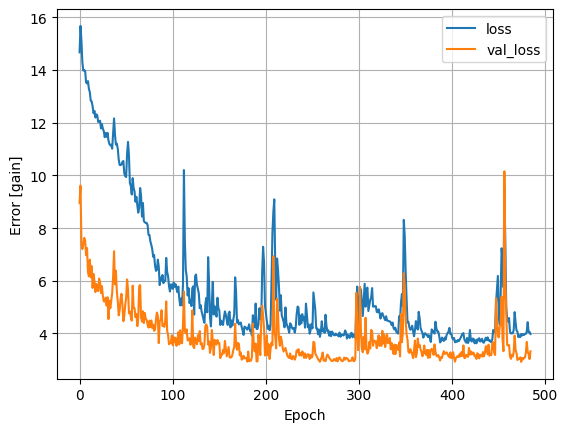

In [8]:
plot_loss(1, history_dnn, 15)

In [9]:
X_test_full = pd.read_csv(TEST_FEATURE_PATH)
X_test = X_test_full.iloc[:, 5:]
X_test[preProcess_labels] = X_test[preProcess_labels].map(dB_to_linear)

# Predict on test set
y_pred_array = base_model.predict(X_test)

# Convert prediction to DataFrame
y_pred = pd.DataFrame(y_pred_array, columns=y_train.columns)

wss_cols = [col for col in X_test.columns if 'dut_wss_activated_channel_index' in col.lower()]
wss_cols_sorted = sorted(wss_cols)

label_cols = [col for col in y_train.columns if 'calculated_gain_spectra' in col.lower()]
label_cols_sorted = sorted(label_cols)

# Save to CSV
mask = X_test[wss_cols].values == 1
y_pred = pd.DataFrame(np.where(mask, y_pred.values, np.nan),
    columns=label_cols_sorted
)

y_pred.fillna(0, inplace=True)

kaggle_ID = X_test_full.columns[0]
y_pred.insert(0, kaggle_ID, X_test_full[kaggle_ID].values)

# Save predictions
output_path = "../Features/Test/test_labels.csv"
y_pred.to_csv(output_path, index=False)

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
